Data Retrieved From: https://archive.ics.uci.edu/dataset/1/abalone

# Goal and Introduction

The goal is to use this dataset to predict the age of an abalone based on easier to measure criteria rather than rings (for which you have to cut into the specimen to count).

Most of the variables are already numerical, and the dataset is not missing values, according to the UCI website, so much of the annoying cleaning and encoding can be avoided. Based on the target data, it will be somewhat difficult to predict the age completely accurately. This is because there are many ages represented and the edges have very few data points. 

Random Forest might be the best for such a dataset but that's basically a guess.

## General Outline

* Ensure everything has the correct variable types, and look at the distribution of variables
* Apply Random Forest Classification to the data set
* Review the Results and attempt to optimize the model

In [22]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [4]:
X.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object

In [5]:
pd.unique(X['Sex'])

array(['M', 'F', 'I'], dtype=object)

In [6]:
y.dtypes

Rings    int64
dtype: object

In [19]:
y.value_counts()

Rings
9        689
10       634
8        568
11       487
7        391
12       267
6        259
13       203
14       126
5        115
15       103
16        67
17        58
4         57
18        42
19        32
20        26
3         15
21        14
23         9
22         6
27         2
24         2
26         1
1          1
25         1
2          1
29         1
Name: count, dtype: int64

In [7]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [8]:
X.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [9]:
JointFrame = X.join(y)
JointFrame.corr(numeric_only=True)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


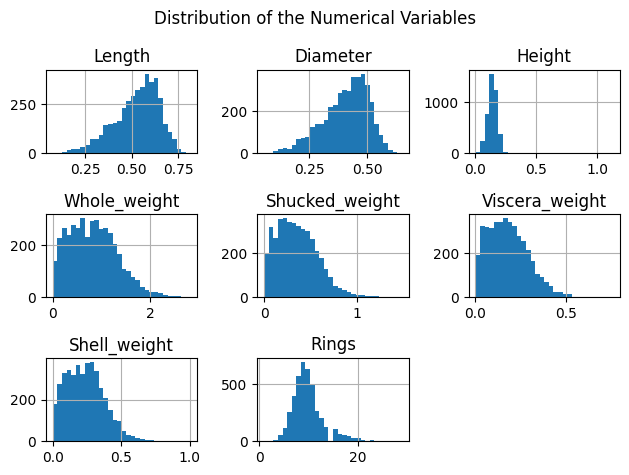

In [10]:
JointFrame.drop(['Sex'], axis=1).hist(bins=30)
plt.suptitle("Distribution of the Numerical Variables")
plt.tight_layout()

In [11]:
X['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

<Axes: >

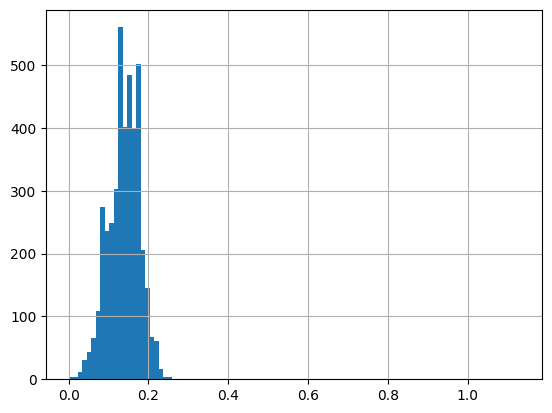

In [12]:
X['Height'].hist(bins=100)

array([[<Axes: title={'center': 'Rings'}>]], dtype=object)

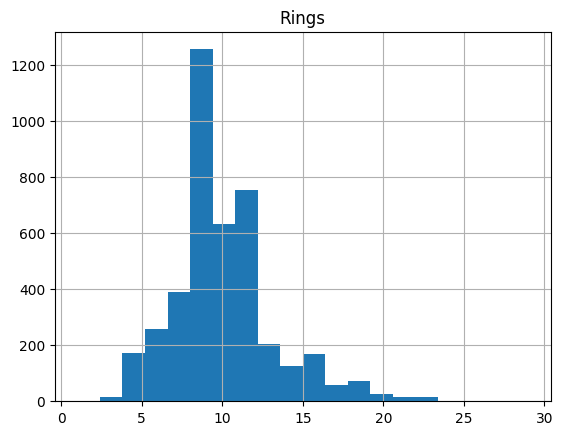

In [43]:
y.hist(bins=20)

In [13]:
X_encoded = pd.get_dummies(X, columns=["Sex"])
X_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,False,True,False


Most of the data seems distributed somewhat normally, with there often being a left-sided bias, which is good. Outliers are not a significant worry, and with *Sex* encoded it should be easy to make the data work for most models. It's difficult to say which model will work well for the data, so a variety of linear models and Random Forest models will be tested and the top 3 or so will be picked and anlayzed further.

In [81]:
from sklearn import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y)

In [77]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix

In [84]:
models = [
    ('LR', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('EN', ElasticNet()),
    ('RFC', RandomForestClassifier()),
    ('RFR', RandomForestRegressor())
]

for name, model in models:
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    print(" %s with MSE of %s and score of %s" % (name, mean_squared_error(y_test, y_pred), model.score(X_test, y_test)))

 LR with MSE of 4.843784492601661 and score of 0.5467039938526848
 Ridge with MSE of 4.925714278818663 and score of 0.5390367566059833
 Lasso with MSE of 10.712928618975301 and score of -0.002548268722518232
 EN with MSE of 9.832834218328497 and score of 0.07981362773574752
 RFC with MSE of 6.668899521531101 and score of 0.2555023923444976
 RFR with MSE of 4.824346315789474 and score of 0.5485230772427918


Linear Regression, Ridge, and Random Forest Regressor give the best results, but they're still pretty bad. There will likely have to be significant optimization of hyperparameters for it to be acceptable. Though, there may be some way to optimize the test and train sets to better the chance of better results.